# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: *\<BOULEDROUA Noah\>*

**Matricola**: *\<2181745\>*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 20th** session, you should upload it by **January 17th, 23:59 Rome time**.

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib.pyplot as plt
from tqdm import tqdm

### Instructions

1. The homework is divided into three exercises. The first two (**10 points**) are mandatory for everyone. The third one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>. **Same goes for LLM-generated material**.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (no external libraries) and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

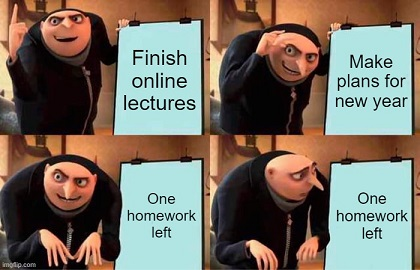

## Warmup: Data loading

For this part, select a dataset that is adequate for an autoregressive modelling task, keeping in mind task complexity with respect to the available hardware. Alternatively, take a generic dataset and transform it in a suitable way. Some examples (non exhaustive list):

1. Any text dataset can be converted to a next-token prediction dataset. You are free to use an existing tokenizer or train the tokenizer from scratch.
2. Time series are also naturally convertible to autoregressive scenarios.
3. For images you can convert them in multiple ways, e.g., as a sequence of pixels, as a sequence of patches (as in ViTs), as a sequence of bytes...
4. Other types of data, such as audio, graphs, DNA sequences, etc., are also feasible based on your interest.

> ⭕ For this homework, creativity is appreciated! Look around in the literature for inspiration (e.g., PixelRNN, pixel language modeling, audio autoregression, conditional models, ...). The fancier the better, according to your judgment.

*   You can use any data processing you want here (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied. Show some examples of tokenized sequences and / or some statistics (e.g., tokens count, sequence length, ...).*

**TODO**: add description here (1-2 paragraphs).

In [ ]:
pip install yfinance

## ***Description of the dataset*** :
The dataset used in this project is derived from historical stock market data for Apple Inc. (AAPL), spanning from January 1, 2015, to December 31, 2023. The data was downloaded using the yfinance library and includes key financial indicators : closing and opening price, highest and lowest price and volume.
I will focus exclusively on the closing price for this analysis. The input sequences (X_train) will consist of sliding windows of length 100 days, capturing the recent historical data. The corresponding target value (y_train) will be the closing price for day 101, which the RNN aims to predict. Similarly, separate sets for testing (X_test and y_test) have been prepared to evaluate the model's performance.

In [ ]:
import yfinance as yf
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#Download stock market data for Apple (APPL)
symbol = "AAPL"
data = yf.download(symbol, start="2015-01-01", end="2023-12-31")
close_prices = data['Close'].values

#Normalisation of the close prices
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

#Prepare data into sequence
def data_preparation(sequence_length, data):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

sequence_length = 60

X, y = data_preparation(sequence_length, close_prices_scaled)

#Divise data between training and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)
X_test = jnp.array(X_test)
y_test = jnp.array(y_test)


[*********************100%***********************]  1 of 1 completed


In [ ]:
X_train.shape

(1731, 100, 1)

### Exercise 1: Training a recurrent model (7 points)

For this exercise, you are asked to implement a recurrent neural network, **entirely in JAX** (no higher-level libraries). Examples include all the content of Lecture 10 in the course (vanilla RNNs, structured state-space models, ...) but also other types of recurrent models you may find in the literature.

> 🟨 Depending on the implementation, you may need to be careful in the forward pass. For example, consider using [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) for implementing the loop of a vanilla RNN.

> 🟥 Remember that the homework must be done fully in JAX, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the model. Train the model and show some plots to visualize the training (e.g., loss curves, perplexity, ...).*

**TODO**: add description here (1-2 paragraphs).

# Description :

I implement a Vanilla RNN operating in a many-to-one mode. It takes a sequence as input to predict the value following that sequence, and the loss is calculated based on this predicted value.

In [ ]:
#Parameters of the RNN
input_size = 1  #Size of each element of the sequence
hidden_size = 60 #Size of the hidden layer
output_size = 1 #Size of the predicted value

#Initialisation of weights and bias
def init_params(key):
    key1, key2, key3 = jax.random.split(key, num = 3)
    Wx = jax.random.normal(key1, (1,hidden_size))*0.1 #Entry weights
    Wh = jax.random.normal(key2, (hidden_size, hidden_size))*0.1  #Hidden state weights
    Wy = jax.random.normal(key3, (hidden_size, output_size))*0.1  #Output weights
    bh = jnp.zeros(hidden_size)  #Bias of the hidden layer
    by = jnp.zeros(output_size)  #Bias of the output
    return Wx, Wh, Wy, bh, by

def rnn_forward(params, x):
    wx, wh,wy, bh, by = params

    #Initialisation of the hidden state
    h = jnp.zeros((1, hidden_size))

    #Hidden state update function at each time step
    def step(carry, x_t):
        h_t = carry
        h_next = jnp.tanh(jnp.dot(x_t,wx) + jnp.dot(h_t, wh) + bh)
        return h_next, h_next

    #jax.lax.scan to apply hidden state update over all the sequence
    h, _ = jax.lax.scan(step, h, x)

    #Output computation
    y = jnp.dot(h, wy) + by
    return y

def rnn_forward_vmap(params,X):
  return jax.vmap(rnn_forward,in_axes=(None,0))(params,X)

def loss_fn(params, x, y_true):
    y_pred = rnn_forward_vmap(params, x)[:, :, -1]
    return jnp.mean((y_pred - y_true) ** 2)

grad_fn = jax.value_and_grad(loss_fn)

def update_params(params, grads, learning_rate):
    updated_params = jax.tree_util.tree_map(lambda p, grad_p: p - learning_rate * grad_p, params, grads)
    return updated_params

loss_history = []
grad_history = []

def model_training(X_train, y_train, params, epochs, learning_rate):
    for epoch in tqdm(range(epochs)):
        loss, grads = grad_fn(params, X_train, y_train)
        params = update_params(params, grads, learning_rate)
        grad_w = grads[0]
        grad_history.append(jnp.linalg.norm(grad_w))
        loss_history.append(loss)
    return params

In [ ]:
#Training of the model
key = jax.random.PRNGKey(0)
params = init_params(key)
params_opti = model_training(X_train, y_train, params, epochs=100, learning_rate=0.01)

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


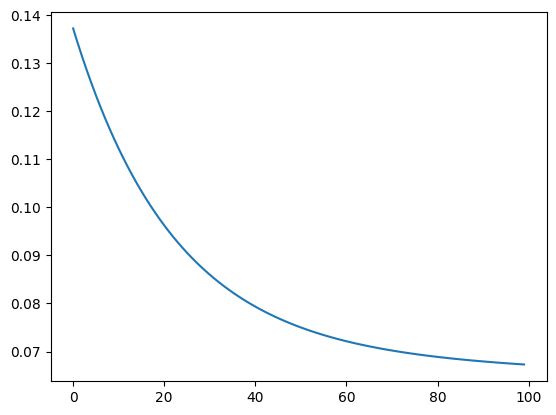

In [ ]:
plt.plot(loss_history)

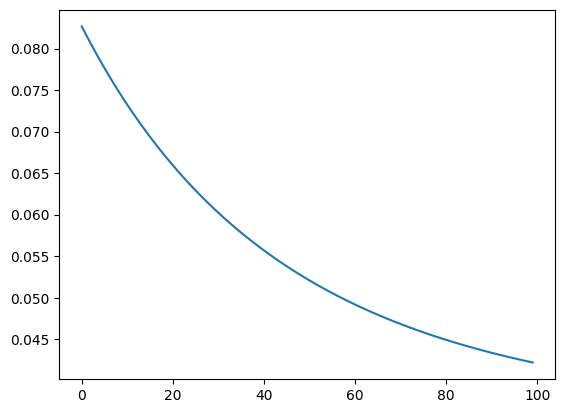

In [ ]:
plt.plot(grad_history)

### Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

**TODO**: add description here (1-2 paragraphs).

### Description :
For this autoregressive generation task, I used sequences of Apple stock prices over 75 days from the test set. I then predicted the next 25 days autoregressively and compared the prediction with the actual sequence using a graph.



In [ ]:
import jax.numpy as jnp
def regressive_autogeneration(sequence,length,params):
  for k in range(length):
    new_element = rnn_forward(params,sequence)
    sequence = jnp.concatenate((sequence,new_element),axis=0)
  return(sequence)

In [ ]:
partial_sequence1 = X_test[213][:25]
total_sequence1 = X_test[213]

partial_sequence2 = X_test[27][:25]
total_sequence2 = X_test[27]

In [ ]:
generated_sequence1 = regressive_autogeneration(partial_sequence1,35,params_opti)
generated_sequence2 = regressive_autogeneration(partial_sequence2,35,params_opti)

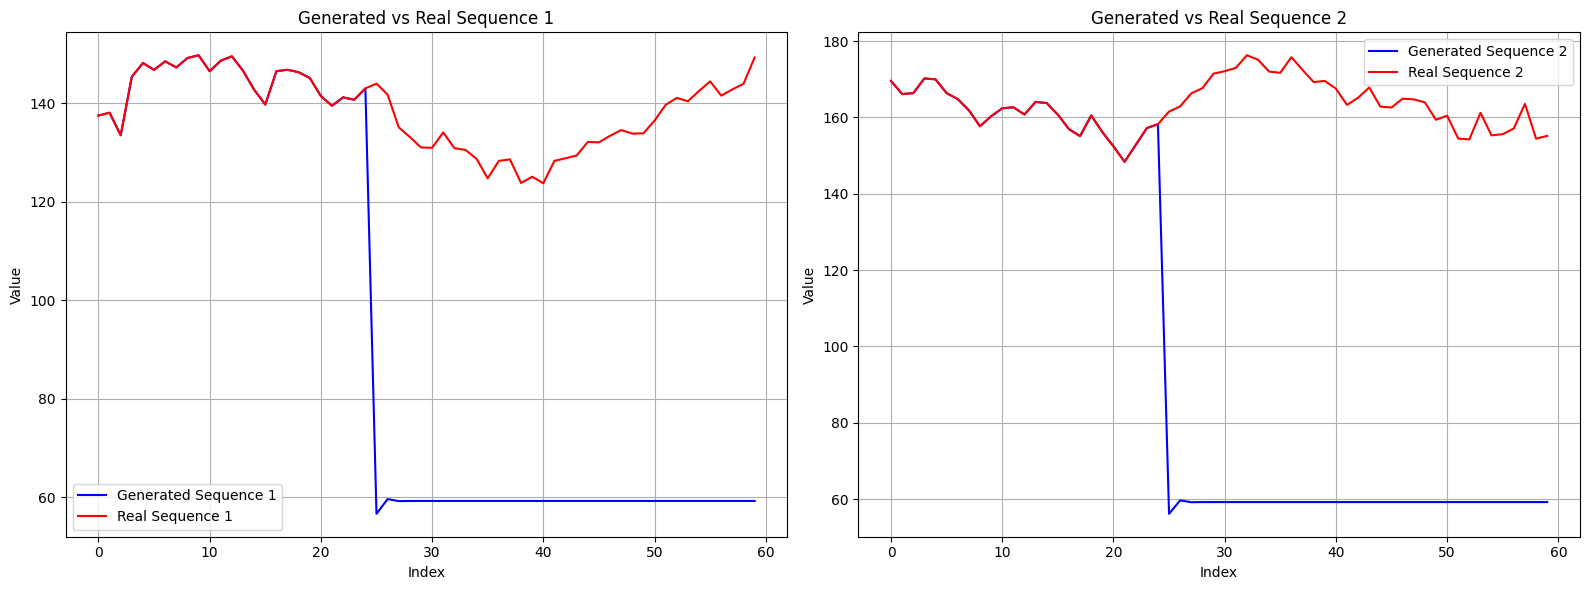

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Generated Sequence 1 vs Real Sequence 1
axs[0].plot(scaler.inverse_transform(generated_sequence1), label="Generated Sequence 1", color='blue')
axs[0].plot(scaler.inverse_transform(total_sequence1), label="Real Sequence 1", color='red')
axs[0].set_title("Generated vs Real Sequence 1")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].grid(True)

# Generated Sequence 2 vs Real Sequence 2
axs[1].plot(scaler.inverse_transform(generated_sequence2), label="Generated Sequence 2", color='blue')
axs[1].plot(scaler.inverse_transform(total_sequence2), label="Real Sequence 2", color='red')
axs[1].set_title("Generated vs Real Sequence 2")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Value")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

plt.show()


### Exercise 3: Beam search (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercises 1&2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1&2&3 for a total of *15 points*.

In standard autoregressive modeling, at every iteration you sample the element with the highest associated probability (e.g., the $\arg\max$ for a discrete distribution). This is known as **greedy decoding**. However, this may result in completed sequences with low probability.

A common modification is **beam search** ([link](https://d2l.ai/chapter_recurrent-modern/beam-search.html)), where at every iteration we keep track of $k$ possible sequences (called **beams**). See also Section 8.4.2 in the book.

**TODO**: For this exercise, implement a beam search decoding procedure for your model, and show some examples of generation, comparing them to the result of greedy decoding.

In [ ]:
# TODO: Your code here.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

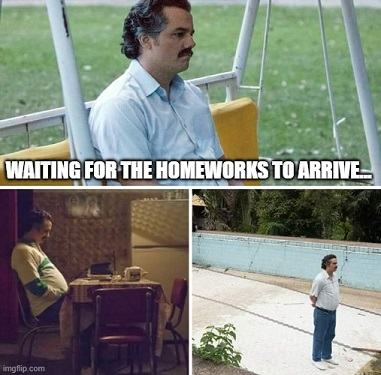